In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql.functions import isnan, when, count, concat, lit, col, explode,replace, regexp_replace, udf,length, lower, regexp_replace, array_union, array_join
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import StructType, StructField, StringType, BooleanType,ArrayType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
import pyspark.sql.utils
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer


creamos sesion para usar pyspark


In [2]:
SpSesion = SparkSession \
          .builder \
          .appName('etl') \
          .getOrCreate() 

In [3]:
SpContext = SpSesion.sparkContext

vamos a cargar datos


este archivo fue modificado con notepad++ usando expresiones regulares  cai 3 dias corrigiendo errores   para evitar tener records corrupts donde perdia casi el 80% del dataframe

In [4]:
path = 'user_reviews_modificado2.json'

In [5]:
schema = StructType([
        StructField("user_id", StringType()),
        StructField("user_url", StringType()),
        StructField("reviews", ArrayType(StructType([
            StructField("funny", StringType()),
            StructField("posted", StringType()),
            StructField("last_edited", StringType()),
            StructField("item_id", StringType()),
            StructField("helpful", StringType()),
            StructField("recommend", BooleanType()),
            StructField("review", StringType())
    ])))
])

In [6]:
df = SpSesion.read.json(path,schema=schema)

Vamos a pasar a explorar el archivo y ver de que se trata, tipos de columnas variables  etc


In [7]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_url: string (nullable = true)
 |-- reviews: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- funny: string (nullable = true)
 |    |    |-- posted: string (nullable = true)
 |    |    |-- last_edited: string (nullable = true)
 |    |    |-- item_id: string (nullable = true)
 |    |    |-- helpful: string (nullable = true)
 |    |    |-- recommend: boolean (nullable = true)
 |    |    |-- review: string (nullable = true)



In [8]:
print('los tipod de tados son  para cada columna \n',df.dtypes)
print()
print(f'tiene {len(df.columns)} columnas ')
print('las columnas son \n',df.columns)
print()
print(f'el dataset tiene {df.count()} filas')
print()



los tipod de tados son  para cada columna 
 [('user_id', 'string'), ('user_url', 'string'), ('reviews', 'array<struct<funny:string,posted:string,last_edited:string,item_id:string,helpful:string,recommend:boolean,review:string>>')]

tiene 3 columnas 
las columnas son 
 ['user_id', 'user_url', 'reviews']

el dataset tiene 25798 filas



In [9]:
df

DataFrame[user_id: string, user_url: string, reviews: array<struct<funny:string,posted:string,last_edited:string,item_id:string,helpful:string,recommend:boolean,review:string>>]

In [10]:
df.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- user_url: string (nullable = true)
 |-- reviews: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- funny: string (nullable = true)
 |    |    |-- posted: string (nullable = true)
 |    |    |-- last_edited: string (nullable = true)
 |    |    |-- item_id: string (nullable = true)
 |    |    |-- helpful: string (nullable = true)
 |    |    |-- recommend: boolean (nullable = true)
 |    |    |-- review: string (nullable = true)



In [11]:
df.show(10)

+-----------------+--------------------+--------------------+
|          user_id|            user_url|             reviews|
+-----------------+--------------------+--------------------+
|76561197970982479|http://steamcommu...|[{NULL, Posted No...|
|          js41637|http://steamcommu...|[{NULL, Posted Ju...|
|        evcentric|http://steamcommu...|[{NULL, Posted Fe...|
|            doctr|http://steamcommu...|[{NULL, Posted Oc...|
|        maplemage|http://steamcommu...|[{NULL, Posted Ap...|
|           Wackky|http://steamcommu...|[{NULL, Posted Ma...|
|76561198079601835|http://steamcommu...|[{NULL, Posted Ma...|
|      MeaTCompany|http://steamcommu...|[{NULL, Posted Ju...|
|76561198089393905|http://steamcommu...|[{NULL, Posted Fe...|
|76561198156664158|http://steamcommu...|[{NULL, Posted Ju...|
+-----------------+--------------------+--------------------+
only showing top 10 rows



Comienza la limpieza borrando columnas que no usaremos

In [12]:
df = df.drop('user_url')

COMENZAMOS A OIRIENTAR EL etl PARA LO QUE PIDEN LOS ENDPOINTS DE fAST API

In [13]:

df_null_reviews = df.filter(df.reviews.isNull())
num_null_rows = df_null_reviews.count()
print("El dataset tiene", num_null_rows, "datos nulos en la columna 'reviews'")

El dataset tiene 627 datos nulos en la columna 'reviews'


hacemos el explode para poner al mismo nivellas subcolumnas que tiene nuestro dataset como vimos anteriormente en nuestro SChema

In [14]:

df = df.withColumn("reviews", explode(df.reviews))

una vez creadas nuestras columnas donde seran alojado el explode anterior

In [15]:
df = df.withColumn("funny", col("reviews.funny"))
df = df.withColumn("posted", col("reviews.posted"))
df = df.withColumn("last_edited", col("reviews.last_edited"))
df = df.withColumn("item_id", col("reviews.item_id"))
df = df.withColumn("helpful", col("reviews.helpful"))
df = df.withColumn("recommend", col("reviews.recommend"))
df = df.withColumn("review", col("reviews.review"))

In [16]:
df = df.drop("reviews") #borramos nuestro review que ya fue expandido

In [17]:
df.show(truncate=False)

+-----------------+-----+-------------------------+-----------------------------+-------+-----------------------------------------------+---------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id          |funny|posted                   |last_edited                  |item_id|helpful                                        |recommend|review                                                                                                    

saco columnas que no utilizaremos

In [18]:
df = df.drop('funny')
df = df.drop('helpful')
df = df.drop('last_edited')
df = df.drop('recommend')

In [19]:
df.show(truncate=False)

+-----------------+-------------------------+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id          |posted                   |item_id|review                                                                                                                                                                                                                                                                                                

seguimos trabjando para darle forma a nuestro Dataset para poder hacer un analisis de sentimiento a nuestra nueva column review

In [21]:
total_rows = df.count()
unique_apps = df.select("review").distinct().count()
usuarios_diferentes = df.select("user_id").distinct().count()
null_apps = df.filter(col("review").isNull()).count()
repeated_apps = total_rows - unique_apps - null_apps

print("Número total de filas:", total_rows)
print("Número de review distintos", unique_apps)
print("Número de review con valores nulos:", null_apps)
print("Número de review repetidos:", repeated_apps)
print("Número de usuarios diferentes:", usuarios_diferentes)

Número total de filas: 56642
Número de review distintos 52685
Número de review con valores nulos: 0
Número de review repetidos: 3957
Número de usuarios diferentes: 24837


Ahora haremos trabajando unicamente con el dataframe en pandas  , ahora que hemos acomodado nuestro Dataframe mucho mejor

In [22]:
pandas_dataset = df.toPandas()

In [23]:
pandas_dataset

,user_id,posted,item_id,review
0,76561197970982479,"Posted November 5, 2011.",1250,Simple yet with great replayability. In my opi...
1,76561197970982479,"Posted July 15, 2011.",22200,its unique and worth a playthrough.
2,76561197970982479,"Posted April 21, 2011.",43110,Great atmosphere. The gunplay can be a bit chu...
3,js41637,"Posted June 24, 2014.",251610,I know what you think when you see this title ...
4,js41637,"Posted September 8, 2013.",227300,For a simple (its actually not all that simple...
...,...,...,...,...
56637,76561198312638244,Posted July 10.,70,a must have classic from steam definitely wort...
56638,76561198312638244,Posted July 8.,362890,this game is a perfect remake of the original ...
56639,LydiaMorley,Posted July 3.,273110,had so much fun plaing this and collecting res...
56640,LydiaMorley,Posted July 20.,730,:D


sacamos los valores nulos de nuestros comentarios, convertimos a str la columna por las dudas y ponemos en minuscula ya que es un requisito de normalizacion para aplicar la libreria  

In [24]:
pandas_dataset['review'] = pandas_dataset['review'].astype(str)
pandas_dataset.dropna(subset=['review'], inplace=True)  # Elimina las filas con valores nulos en 'review'
pandas_dataset['review'] = pandas_dataset['review'].str.lower()

In [25]:
pandas_dataset

,user_id,posted,item_id,review
0,76561197970982479,"Posted November 5, 2011.",1250,simple yet with great replayability. in my opi...
1,76561197970982479,"Posted July 15, 2011.",22200,its unique and worth a playthrough.
2,76561197970982479,"Posted April 21, 2011.",43110,great atmosphere. the gunplay can be a bit chu...
3,js41637,"Posted June 24, 2014.",251610,i know what you think when you see this title ...
4,js41637,"Posted September 8, 2013.",227300,for a simple (its actually not all that simple...
...,...,...,...,...
56637,76561198312638244,Posted July 10.,70,a must have classic from steam definitely wort...
56638,76561198312638244,Posted July 8.,362890,this game is a perfect remake of the original ...
56639,LydiaMorley,Posted July 3.,273110,had so much fun plaing this and collecting res...
56640,LydiaMorley,Posted July 20.,730,:d


Creamos la funcion para usar usar la lib TextBlob

In [26]:
def get_sentiment(text):
    analysis = TextBlob(str(text))
    if analysis.sentiment.polarity > 0:
        return 'buena'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'mala'


creamos la columna sentiment haciendo el apply de la funcion get sentiment

In [27]:
pandas_dataset['sentiment'] = pandas_dataset['review'].apply(get_sentiment)

In [28]:
pandas_dataset

,user_id,posted,item_id,review,sentiment
0,76561197970982479,"Posted November 5, 2011.",1250,simple yet with great replayability. in my opi...,buena
1,76561197970982479,"Posted July 15, 2011.",22200,its unique and worth a playthrough.,buena
2,76561197970982479,"Posted April 21, 2011.",43110,great atmosphere. the gunplay can be a bit chu...,buena
3,js41637,"Posted June 24, 2014.",251610,i know what you think when you see this title ...,buena
4,js41637,"Posted September 8, 2013.",227300,for a simple (its actually not all that simple...,mala
...,...,...,...,...,...
56637,76561198312638244,Posted July 10.,70,a must have classic from steam definitely wort...,buena
56638,76561198312638244,Posted July 8.,362890,this game is a perfect remake of the original ...,buena
56639,LydiaMorley,Posted July 3.,273110,had so much fun plaing this and collecting res...,buena
56640,LydiaMorley,Posted July 20.,730,:d,neutral


borramos columna review  para alivianar nuestro dataset

In [29]:
pandas_dataset = pandas_dataset.drop('review', axis=1)


preparamos la columna posted para extraer y convertir a date time

In [30]:
pandas_dataset['posted'] = pandas_dataset['posted'].str.replace('Posted ', '', 1)
pandas_dataset['posted'] = pandas_dataset['posted'].str.replace(',', '', 1)
pandas_dataset['posted'] = pandas_dataset['posted'].str.replace('.', '', 1)


In [31]:
pandas_dataset

,user_id,posted,item_id,sentiment
0,76561197970982479,November 5 2011,1250,buena
1,76561197970982479,July 15 2011,22200,buena
2,76561197970982479,April 21 2011,43110,buena
3,js41637,June 24 2014,251610,buena
4,js41637,September 8 2013,227300,mala
...,...,...,...,...
56637,76561198312638244,July 10,70,buena
56638,76561198312638244,July 8,362890,buena
56639,LydiaMorley,July 3,273110,buena
56640,LydiaMorley,July 20,730,neutral


hago una extraccion de la columna posted de aquellos que tienen 4 cifras    convierto a 0 las que dan Nan   y luego limpio  esas   todas estas modificaciones son para evitar  problemas en la construccion de la APi

In [32]:
pandas_dataset['year'] = pandas_dataset['posted'].str.extract('(\d{4})')
pandas_dataset['year'] = pandas_dataset['year'].fillna('0').astype(int)
pandas_dataset = pandas_dataset[pandas_dataset['year'] != 0]  # con esta fila saco las que teiene cero 


In [33]:
pandas_dataset

,user_id,posted,item_id,sentiment,year
0,76561197970982479,November 5 2011,1250,buena,2011
1,76561197970982479,July 15 2011,22200,buena,2011
2,76561197970982479,April 21 2011,43110,buena,2011
3,js41637,June 24 2014,251610,buena,2014
4,js41637,September 8 2013,227300,mala,2013
...,...,...,...,...,...
56589,wayfeng,October 14 2015,730,neutral,2015
56592,76561198251004808,October 10 2015,253980,buena,2015
56602,72947282842,October 31 2015,730,mala,2015
56604,ApxLGhost,December 14 2015,730,buena,2015


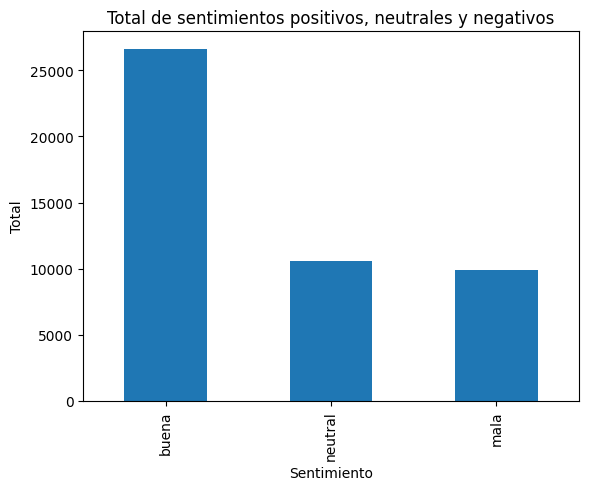

In [34]:



# Gráfico del total de sentimientos positivos, neutrales y negativos
sentimientos = pandas_dataset['sentiment'].value_counts()
sentimientos.plot(kind='bar')
plt.xlabel('Sentimiento')
plt.ylabel('Total')
plt.title('Total de sentimientos positivos, neutrales y negativos')
plt.show()



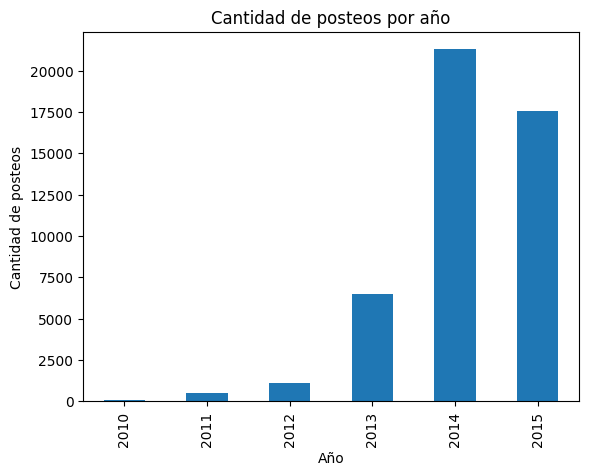

In [35]:



# Calcular la cantidad de posteos por año
posteos_por_año = pandas_dataset['year'].value_counts()

# Crear un gráfico de barras de la cantidad de posteos por año
posteos_por_año.sort_index().plot(kind='bar')
plt.xlabel('Año')
plt.ylabel('Cantidad de posteos')
plt.title('Cantidad de posteos por año')
plt.show()


buscamos outliers de cantidad de posteos por año, solo para tener en cuenta nada mas....

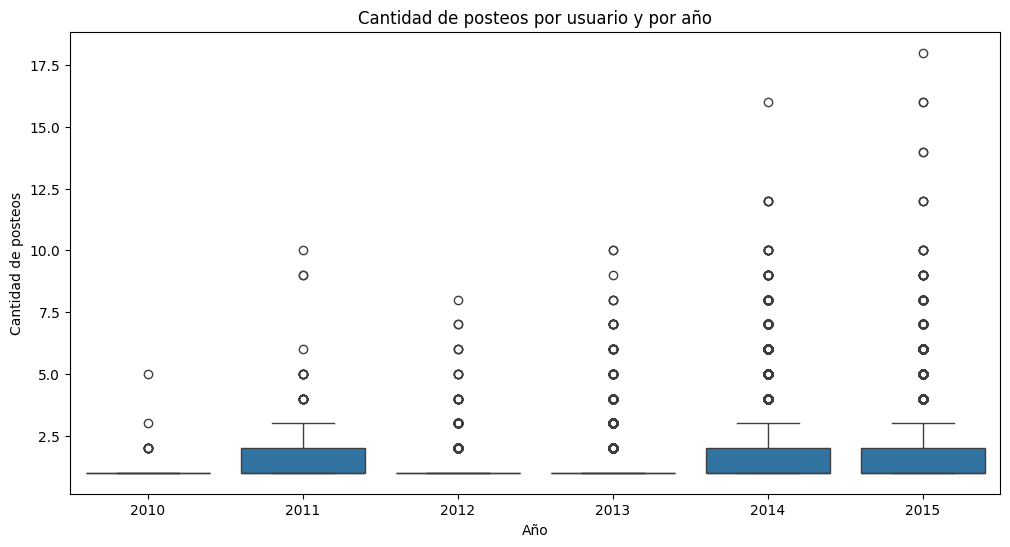

In [36]:
# Calcular la cantidad de posteos por usuario y por año
posteos_por_usuario_y_año = pandas_dataset.groupby(['user_id', 'year']).size().reset_index(name='cantidad_de_posteos')


plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='cantidad_de_posteos', data=posteos_por_usuario_y_año)
plt.xlabel('Año')
plt.ylabel('Cantidad de posteos')
plt.title('Cantidad de posteos por usuario y por año')
plt.show()

In [37]:
posteos_por_usuario_y_año = pandas_dataset.groupby(['user_id', 'year']).size().reset_index(name='cantidad_de_posteos')

usuario_mas_posteos_por_año = posteos_por_usuario_y_año.loc[posteos_por_usuario_y_año.groupby('year')['cantidad_de_posteos'].idxmax()]
print(usuario_mas_posteos_por_año)

                 user_id  year  cantidad_de_posteos
23068             farsel  2010                    5
15838             Hawkez  2011                   10
14333             Corber  2012                    8
9876   76561198083857294  2013                   10
6104   76561198063316459  2014                   16
17882      OfficialSenix  2015                   18


In [38]:
pandas_dataset = pandas_dataset.drop('posted', axis=1)

In [39]:
pandas_dataset

,user_id,item_id,sentiment,year
0,76561197970982479,1250,buena,2011
1,76561197970982479,22200,buena,2011
2,76561197970982479,43110,buena,2011
3,js41637,251610,buena,2014
4,js41637,227300,mala,2013
...,...,...,...,...
56589,wayfeng,730,neutral,2015
56592,76561198251004808,253980,buena,2015
56602,72947282842,730,mala,2015
56604,ApxLGhost,730,buena,2015


In [40]:
conteo_usuarios  = pandas_dataset['user_id'].nunique()
print(conteo_usuarios)

22223


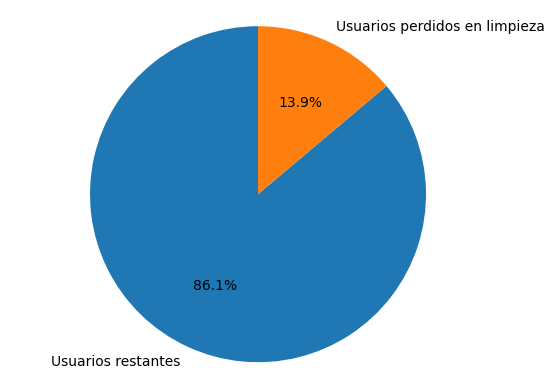

In [41]:
total_usuarios = 25798
usuarios_restantes = 22223
usuarios_perdidos = total_usuarios - usuarios_restantes
porcentaje_usuarios_restantes = (usuarios_restantes/total_usuarios)*100
porcentaje_usuarios_perdidos = (usuarios_perdidos/total_usuarios)*100
labels = ['Usuarios restantes', 'Usuarios perdidos en limpieza']
sizes = [porcentaje_usuarios_restantes, porcentaje_usuarios_perdidos]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')

plt.show()


In [ ]:
#pandas_dataset.to_csv('user_review_final.csv', index=False)